# HDD 추천 모델

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

- 사용자의 HDD 선택 기준은 아래와 같다.
    - 가격
    - 용량
    - 속도
    - 사용 용도(컴퓨터가 켜져 있는 시간, 쓰기 정도, 읽기 정도)
- 자체 구축한 실사용 데이터 기반 DB를 이용하여 사용자가 원하는 HDD 스펙을 입력할 수 있도록 한다.
    - 예를 들어 가격은 10만원 이하였으면 좋겠고, 용량은 적어도 1TB, 속도는 최소 100m/s가 나왔으면 좋겠다. 데이터 백업용으로 사용할 것이다(백업용 디스크는 켜져 있는 시간이 작을 것이고, 쓰기량은 많고, 읽기량은 적을 것).
- 사용 용도는 다음과 같이 정리해볼 수 있다.
    - 일단, 사용자의 패턴(가정용, 연구실용, 데이터센터용)을 따지지 말고, 정량적으로 얼마나 사용할 지를 입력받자.
- 그러면 다음과 같은 모델을 생각해볼 수 있을 것이다.
    - 추천 모델 : 가격, 용량, 속도에 대해 범위 탐색을 진행하여 하드디스크를 추천해주는 모델
    - 비추천 모델 : 실사용 데이터(HDD가 켜져 있는 시간, 쓰기 정도, 읽기 정도)에 따른 HDD 실패율을 분석하여 가장 실패 확률이 높다고 판단되는 HDD를 선별해주는 모델, 딥러닝을 이용할지 아니면 확률밀도함수를 구해 앙상블을 할지 "고민" 중
- 위의 두 모델을 앙상블하여 추천된 모델과 비추천 모델을 둘 다 제시하여 사용자가 HDD를 선택할 수 있는 폭을 넓혀준다.

## Load Dataset

In [4]:
path_parent = './data/2022'
path_files = os.listdir(path_parent)
path_files.sort()

print(path_files[0], len(path_files))

2022-01-01.csv 365


### HDD Specification 불러오기

In [5]:
hdd_spec_df = pd.read_csv('./hdd-model-specs-2022.csv')
hdd_spec_df

Model Type          Company     Price  Capacity     RPM  \
0         CT250MX500SSD1  SSD          Crucial   37920.0      0.25     NaN   
1            DELLBOSS VD  SSD             DELL       NaN       NaN     NaN   
2   HGST HDS5C4040ALE630  HDD             HGST  455120.0      4.00  5700.0   
3   HGST HDS724040ALE640  HDD             HGST  146134.0      4.00  7200.0   
4   HGST HMS5C4040ALE640  HDD             HGST       NaN      4.00  5700.0   
..                   ...  ...              ...       ...       ...     ...   
70          WDC WD60EFRX  HDD  Western Digital  455000.0      6.00  5400.0   
71       WDC WDS250G2B0A  SSD  Western Digital   38370.0      0.25     NaN   
72   WDC WUH721414ALE6L4  HDD  Western Digital  558990.0     14.00  7200.0   
73   WDC WUH721816ALE6L0  HDD  Western Digital       NaN     16.00  7200.0   
74   WDC WUH721816ALE6L4  HDD  Western Digital  608970.0     16.00  7200.0   

    Buffer   Read  Write Method  Warranty  Thickness  
0      NaN  560.0  510.0    NaN       5.0        7.0  
1      NaN    NaN    NaN    NaN       NaN        NaN  
2     32.0    NaN    NaN    NaN       NaN       26.1  
3     64.0    NaN    NaN    NaN       2.0       26.1  
4     64.0    NaN    NaN    NaN       3.0       26.1  
..     ...    ...    ...    ...       ...        ...  
70    64.0  175.0  175.0    CMR       3.0       26.1  
71     NaN  550.0  525.0    NaN       5.0        7.0  
72   512.0  267.0  267.0    CMR       5.0       26.1  
73   512.0    NaN    NaN    NaN       NaN       26.1  
74   512.0  262.0  262.0    CMR       5.0       26.1  

[75 rows x 12 columns]

### Feature 선정 기준
- 대부분의 하드디스크에 존재하는 S.M.A.R.T. 속성
- 실사용과 관련된 S.M.A.R.T. 속성 (재할당된 섹터 수 또는 복구 불가한 섹터 수 등은 failure 속성에 이미 선반영 되어있으므로 제외)
- SSD는 데이터에서 제외
- 선정된 Feature에 결측치가 존재하는 데이터는 제외

### Selected Features
- 009: Power-On Hours(RAW, 안정성 지표)
  - 실제 HDD 동작 시간
- 012: Power Cycle Count(RAW, 안정성 지표)
  - HDD를 켜고 끈 횟수
- 241: Total LBAs Written
  - 섹터 크기가 512 bytes라고 가정했을 때 총 기록한 데이터의 양을 알 수 있음
- 242: Total LBAs Read
  - 섹터 크기가 512 bytes라고 가정했을 때 총 읽은 데이터의 양을 알 수 있음
- Price
- Capacity
- RPM
  - 읽기 및 쓰기 속도에 선형적으로 양의 상관관계를 가짐

In [6]:
pd.read_csv('./data/2022/2022-01-01.csv')

date serial_number                 model  capacity_bytes  \
0       2022-01-01      ZLW18P9K         ST14000NM001G  14000519643136   
1       2022-01-01      ZLW0EGC7         ST12000NM001G  12000138625024   
2       2022-01-01      ZA1FLE1P          ST8000NM0055   8001563222016   
3       2022-01-01      ZA16NQJR          ST8000NM0055   8001563222016   
4       2022-01-01  1050A084F97G   TOSHIBA MG07ACA14TA  14000519643136   
...            ...           ...                   ...             ...   
206949  2022-01-01      ZA10MCEQ           ST8000DM002   8001563222016   
206950  2022-01-01      ZA13ZBCT           ST8000DM002   8001563222016   
206951  2022-01-01      ZHZ3QPZX         ST12000NM0008  12000138625024   
206952  2022-01-01  41B0A01LFV8G  TOSHIBA MG08ACA16TEY  16000900661248   
206953  2022-01-01      X0GEV9EC   WDC WUH721414ALE6L4  14000519643136   

        failure  smart_1_normalized  smart_1_raw  smart_2_normalized  \
0             0                73.0   20467240.0                 NaN   
1             0                84.0  228715872.0                 NaN   
2             0                82.0  157857120.0                 NaN   
3             0                84.0  234265456.0                 NaN   
4             0               100.0          0.0               100.0   
...         ...                 ...          ...                 ...   
206949        0                80.0  109616432.0                 NaN   
206950        0                78.0   62303504.0                 NaN   
206951        0                77.0   48195944.0                 NaN   
206952        0               100.0          0.0               100.0   
206953        0               100.0          0.0               138.0   

        smart_2_raw  smart_3_normalized  ...  smart_250_normalized  \
0               NaN                90.0  ...                   NaN   
1               NaN                99.0  ...                   NaN   
2               NaN                91.0  ...                   NaN   
3               NaN                89.0  ...                   NaN   
4               0.0               100.0  ...                   NaN   
...             ...                 ...  ...                   ...   
206949          NaN                92.0  ...                   NaN   
206950          NaN                86.0  ...                   NaN   
206951          NaN                91.0  ...                   NaN   
206952          0.0               100.0  ...                   NaN   
206953         93.0                85.0  ...                   NaN   

        smart_250_raw  smart_251_normalized  smart_251_raw  \
0                 NaN                   NaN            NaN   
1                 NaN                   NaN            NaN   
2                 NaN                   NaN            NaN   
3                 NaN                   NaN            NaN   
4                 NaN                   NaN            NaN   
...               ...                   ...            ...   
206949            NaN                   NaN            NaN   
206950            NaN                   NaN            NaN   
206951            NaN                   NaN            NaN   
206952            NaN                   NaN            NaN   
206953            NaN                   NaN            NaN   

        smart_252_normalized  smart_252_raw  smart_254_normalized  \
0                        NaN            NaN                   NaN   
1                        NaN            NaN                   NaN   
2                        NaN            NaN                   NaN   
3                        NaN            NaN                   NaN   
4                        NaN            NaN                   NaN   
...                      ...            ...                   ...   
206949                   NaN            NaN                   NaN   
206950                   NaN            NaN                   NaN   
206951                   NaN            NaN          

In [7]:
hdd_feature_pkl_path = './temp/' + f"hdd_feature_{path_parent.split('/')[-1]}_20231125.pkl"

if os.path.exists(hdd_feature_pkl_path):
    # load from pickle
    hdd_feature_df = pd.read_pickle(hdd_feature_pkl_path)
    print('cached hdd feature loaded!')
else:
    # create new dataframe
    hdd_feature_df = pd.DataFrame()
    print('there is no cached hdd feature, create new dataframe!')

    for path_file in tqdm(path_files):
        # read csv
        _temp_df = pd.read_csv(path_parent + '/' + path_file)
        # select columns(model, failure, smart_9_raw, smart_12_raw, smart_241_raw, smart_242_raw)
        _temp_df = _temp_df[[
            'serial_number', 'model', 'failure', 'smart_5_raw', 'smart_9_raw', 'smart_241_raw', 'smart_242_raw'
        ]]
        hdd_feature_df = pd.concat([hdd_feature_df, _temp_df], ignore_index=True)

    # save(cache) to pickle
    hdd_feature_df.to_pickle(hdd_feature_pkl_path)


cached hdd feature loaded!


In [8]:
hdd_feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80357762 entries, 0 to 80357761
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   serial_number  object 
 1   model          object 
 2   failure        int64  
 3   smart_5_raw    float64
 4   smart_9_raw    float64
 5   smart_241_raw  float64
 6   smart_242_raw  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 4.2+ GB


In [8]:
hdd_feature_df

serial_number                model  failure  smart_5_raw  \
0             ZLW18P9K        ST14000NM001G        0          0.0   
1             ZLW0EGC7        ST12000NM001G        0          0.0   
2             ZA1FLE1P         ST8000NM0055        0          0.0   
3             ZA16NQJR         ST8000NM0055        0          0.0   
4         1050A084F97G  TOSHIBA MG07ACA14TA        0          0.0   
...                ...                  ...      ...          ...   
80357757      3WJRXE8K  WDC WUH721816ALE6L4        0          0.0   
80357758      3WJXK5YK  WDC WUH721816ALE6L4        0          0.0   
80357759      3WJZY4EJ  WDC WUH721816ALE6L4        0          0.0   
80357760      3WK6NENK  WDC WUH721816ALE6L4        0          0.0   
80357761      3WKWSKHK  WDC WUH721816ALE6L4        0          0.0   

          smart_9_raw  smart_241_raw  smart_242_raw  
0              9937.0   7.553940e+10   1.393253e+11  
1             13174.0   7.024093e+10   1.643633e+11  
2             12781.0   2.530152e+10   1.738541e+11  
3             40970.0   8.320974e+10   3.021204e+11  
4              6104.0            NaN            NaN  
...               ...            ...            ...  
80357757       1316.0            NaN            NaN  
80357758       1321.0            NaN            NaN  
80357759       1317.0            NaN            NaN  
80357760       1323.0            NaN            NaN  
80357761       1308.0            NaN            NaN  

[80357762 rows x 7 columns]

## HDD Feature 분석

- 정말로 아래의 features가 하드디스크의 실패율을 좌우하는가?
    1. 009: Power-On Hours
    2. 241: Total LBAs Written
    3. 242: Total LBAs Read
- [Building structured multi-plot grids](https://seaborn.pydata.org/tutorial/axis_grids.html)

### Scatter Plots

<Axes: xlabel='smart_9_raw', ylabel='smart_5_raw'>

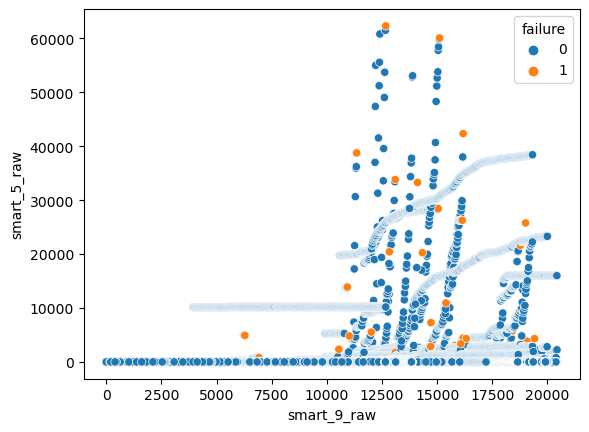

In [10]:
sns.scatterplot(data=hdd_feature_df.query("model == 'ST14000NM001G'"), x="smart_9_raw", y="smart_5_raw", hue="failure")

<Axes: xlabel='smart_9_raw', ylabel='smart_241_raw'>

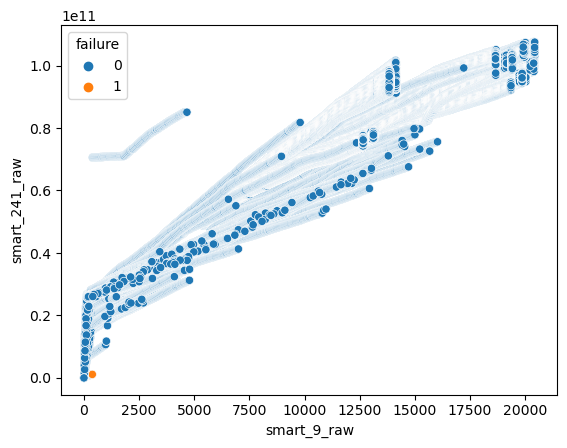

In [11]:
sns.scatterplot(data=hdd_feature_df.query("model == 'ST14000NM001G'"), x="smart_241_raw", y="smart_5_raw", hue="failure")

### Failed HDD Histogram

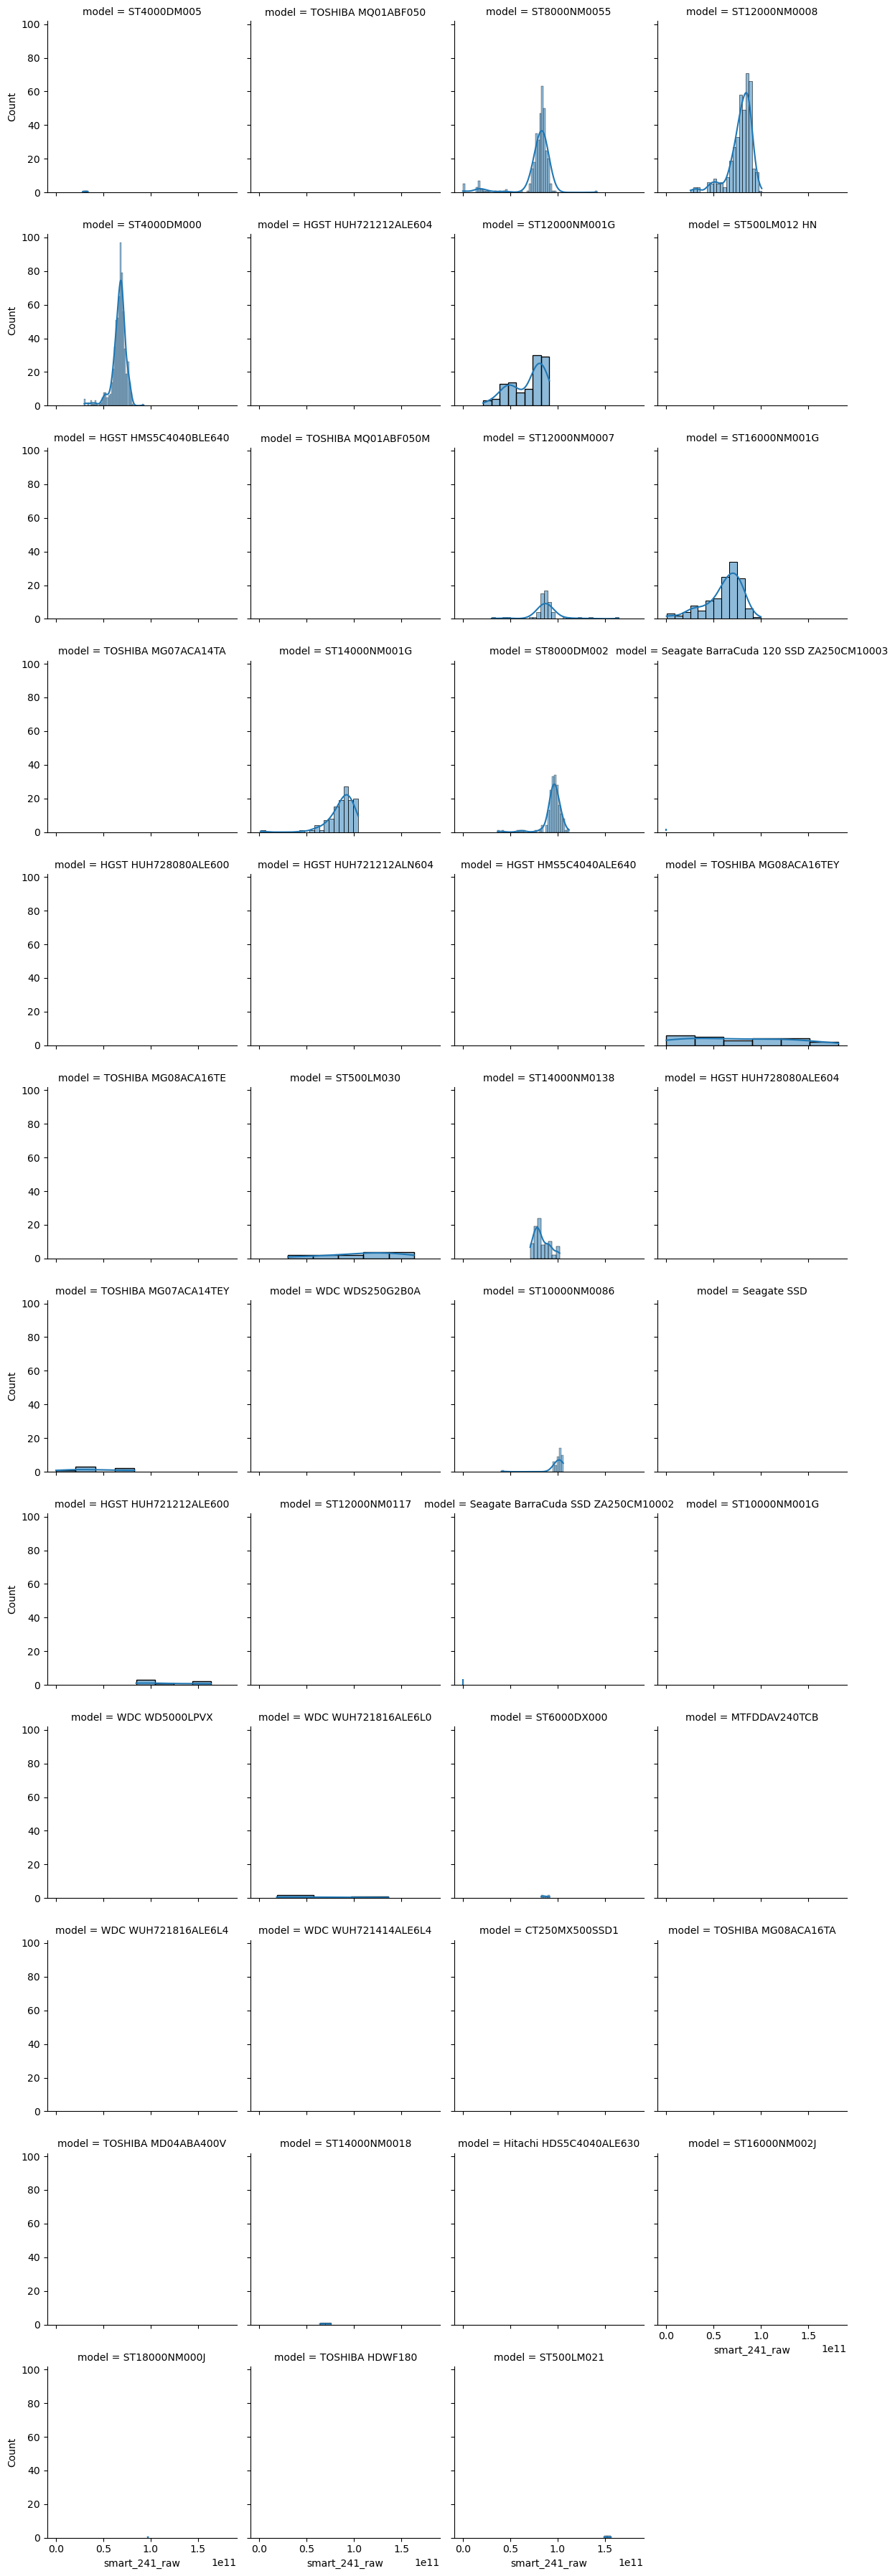

In [8]:
g = sns.FacetGrid(hdd_feature_df[hdd_feature_df['failure'] == 1], col='model', col_wrap=4)
g.map(sns.histplot, 'smart_241_raw', kde=True)

### Power-On Hours

In [9]:
hdd_power_on_hours_df = hdd_feature_df[['model', 'serial_number', 'failure', 'smart_9_raw']].dropna()

In [10]:
failure_df = hdd_power_on_hours_df[hdd_power_on_hours_df['failure'] == 1].groupby(['model', 'serial_number']).min().reset_index()
failure_df

model   serial_number  failure  smart_9_raw
0           CT250MX500SSD1    2107E4F86D54        1       3631.0
1           CT250MX500SSD1    2128E5B7436B        1       3634.0
2           CT250MX500SSD1    2140E5D8E177        1       7114.0
3     HGST HMS5C4040ALE640  PL1331LAG9A36H        1      49793.0
4     HGST HMS5C4040ALE640  PL1331LAGB9KPH        1      46319.0
...                    ...             ...      ...          ...
3120   WDC WUH721816ALE6L4        2CKJDE2J        1       1599.0
3121   WDC WUH721816ALE6L4        2CKJNDTN        1        124.0
3122   WDC WUH721816ALE6L4        2CKR7DHJ        1       1120.0
3123   WDC WUH721816ALE6L4        2PGT26KT        1        794.0
3124   WDC WUH721816ALE6L4        2PGT925V        1       1105.0

[3125 rows x 4 columns]

In [ ]:
success_df = hdd_power_on_hours_df[hdd_power_on_hours_df['failure'] == 0].groupby(['model', 'serial_number']).max().reset_index()
success_df

In [11]:
# groupby serial_number and aggregate only max of smart_9_raw
hdd_power_on_hours_df = hdd_power_on_hours_df.groupby(['model', 'serial_number', 'failure']).max().reset_index()
hdd_power_on_hours_df

model serial_number  failure  smart_9_raw
0            CT250MX500SSD1  2051E4E09F71        0       3889.0
1            CT250MX500SSD1  2053E4E308E9        0       2551.0
2            CT250MX500SSD1  2102E4E5E64F        0       3238.0
3            CT250MX500SSD1  2102E4E70D13        0       2427.0
4            CT250MX500SSD1  2102E4E70D29        0       3025.0
...                     ...           ...      ...          ...
254606  WDC WUH721816ALE6L4      3WKZ2H7K        0       3018.0
254607  WDC WUH721816ALE6L4      3WKZ3UAJ        0       2173.0
254608  WDC WUH721816ALE6L4      3WKZJZUK        0       2192.0
254609  WDC WUH721816ALE6L4      3WKZNUDK        0       1640.0
254610  WDC WUH721816ALE6L4      3XG5ZVGU        0        711.0

[254611 rows x 4 columns]

In [12]:
hdd_power_on_hours_df[hdd_power_on_hours_df['failure'] == 1]

model   serial_number  failure  smart_9_raw
7             CT250MX500SSD1    2107E4F86D54        1       3631.0
29            CT250MX500SSD1    2128E5B7436B        1       3634.0
150           CT250MX500SSD1    2140E5D8E177        1       7114.0
526     HGST HMS5C4040ALE640  PL1331LAG9A36H        1      49793.0
744     HGST HMS5C4040ALE640  PL1331LAGB9KPH        1      46319.0
...                      ...             ...      ...          ...
251434   WDC WUH721816ALE6L4        2CKJDE2J        1       1599.0
251609   WDC WUH721816ALE6L4        2CKJNDTN        1        124.0
252528   WDC WUH721816ALE6L4        2CKR7DHJ        1       1120.0
253020   WDC WUH721816ALE6L4        2PGT26KT        1        794.0
253064   WDC WUH721816ALE6L4        2PGT925V        1       1105.0

[3125 rows x 4 columns]

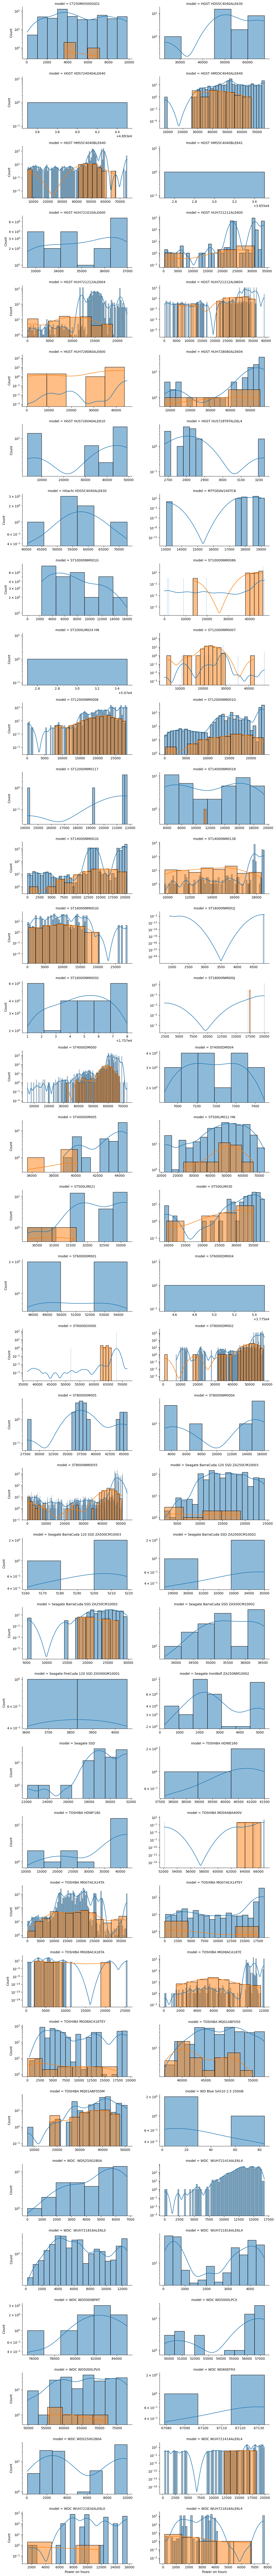

In [13]:
g = sns.FacetGrid(hdd_power_on_hours_df, col='model', hue='failure', col_wrap=2, aspect=2, sharex=False, sharey=False)
g.map(sns.histplot, 'smart_9_raw', kde=True, log_scale=(None, 10))
g.set_axis_labels('Power on hours', 'Count')

# save to png
g.savefig('./output/' + f"hdd_power_on_hours_{path_parent.split('/')[-1]}_new.png")

### Total LBAs Written

In [10]:
hdd_written_df = hdd_feature_df[['model', 'failure', 'smart_241_raw']].dropna()

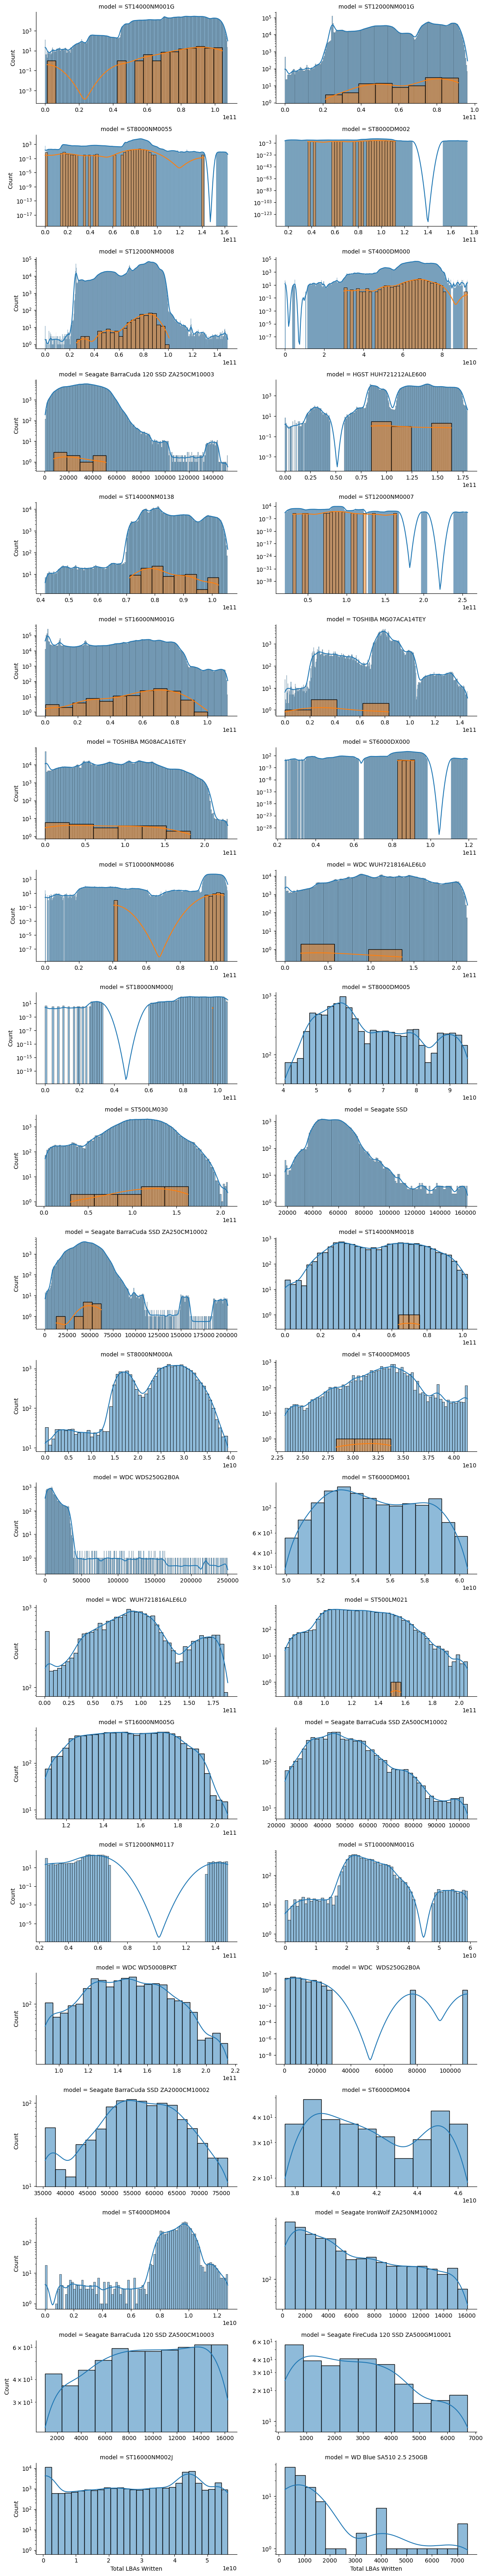

In [45]:
g = sns.FacetGrid(hdd_written_df, col='model', hue='failure', col_wrap=2, aspect=2, sharex=False, sharey=False)
g.map(sns.histplot, 'smart_241_raw', kde=True, log_scale=(None, 10))
g.set_axis_labels('Total LBAs Written', 'Count')

# save to png
g.savefig('./output/' + f"hdd_written_{path_parent.split('/')[-1]}.png")

### Total LBAs Read

In [11]:
hdd_read_df = hdd_feature_df[['model', 'failure', 'smart_242_raw']].dropna()

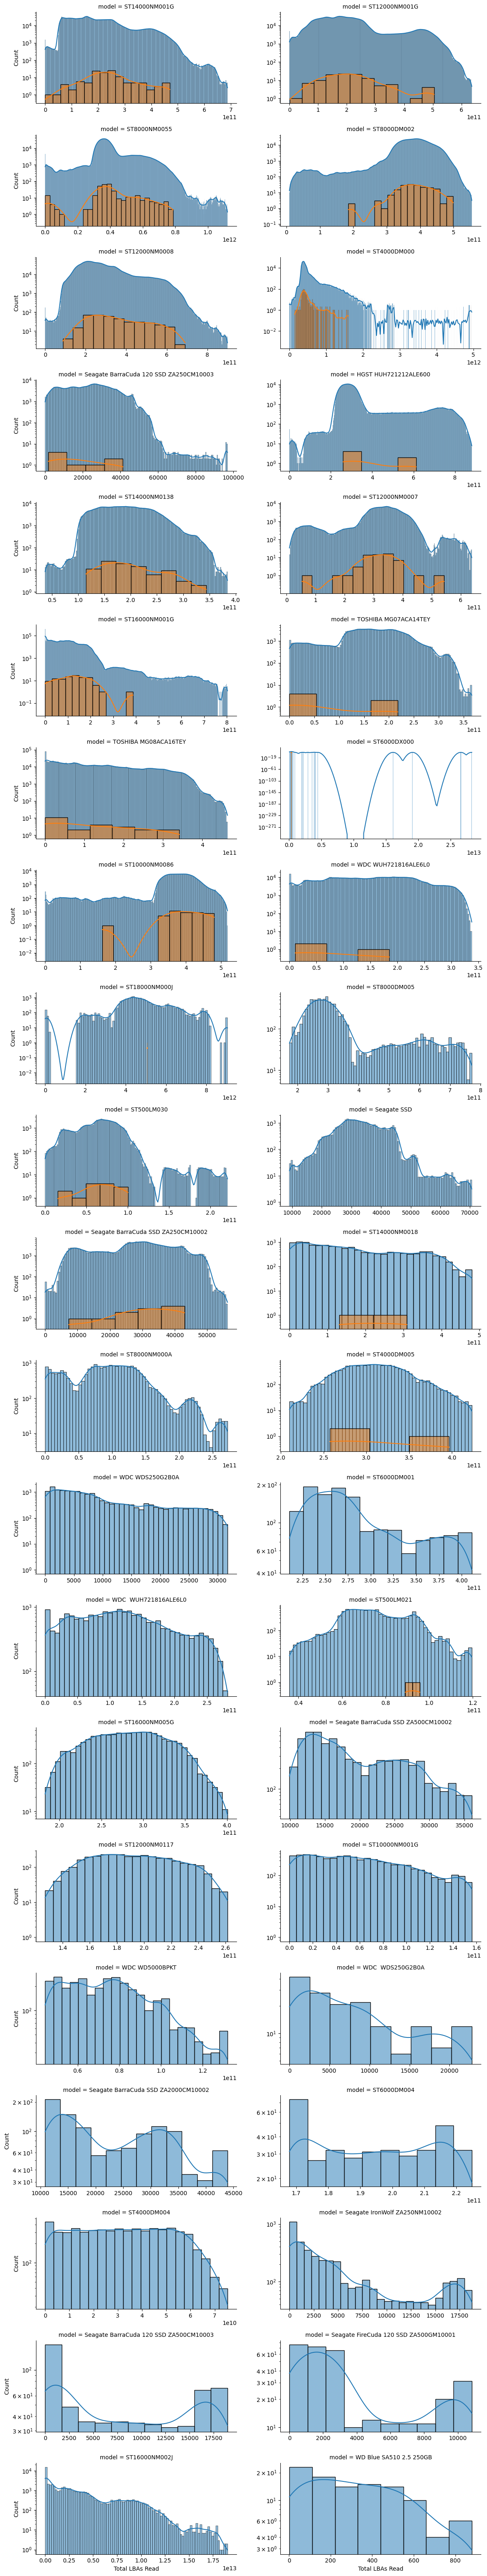

In [46]:
g = sns.FacetGrid(hdd_read_df, col='model', hue='failure', col_wrap=2, aspect=2, sharex=False, sharey=False)
g.map(sns.histplot, 'smart_242_raw', kde=True, log_scale=(None, 10))
g.set_axis_labels('Total LBAs Read', 'Count')

# save to png
g.savefig('./output/' + f"hdd_read_{path_parent.split('/')[-1]}.png")

- 각 feature들은 HDD의 실패에 관여하지 않음을 시각적으로 확인할 수 있다.
- 둘 다 비슷한 분포(모수가 비슷함)를 보인다.
- 이는 곧 각 feature들이 정말로 failure에 영향을 미치는지 알 수 없다.
- 그러므로, 참고 지표로만 사용해야 할 것이다.

## HDD 신뢰도 모델

- 수학적 모델
    - 각 HDD 모델의 특성 x에 따른 누적도수분포 A를 구한다(width of bin은 상수 b로 설정).
    - 각 HDD 모델의 특성 x에 따른 failure 횟수에 대한 누적도수분포 B를 구한다(width of bin은 상수 b로 설정).
    - B를 A로 나누어 failure 비율에 대한 누적도수분포 C를 구한다.
    - C로부터 신뢰도를 계산할 수 있도록 한다.


- 간단한 구현 1 (최적화 필요)
    - 상한선 x에 대해(예를 들어, 최대 사용 시간 10000시간) dataframe query 진행: `df.query("smart_9_raw < 10000")`
    - dataframe을 group하여 failure에 대해 aggregation 진행: `_df.groupby('model').agg({'failure': 'mean'}).reset_index()`
    - 이러면 각 모델에 대한 상한선 x에 대해 failure rate가 계산된다.
    - 그러면 사용자가 제시한 HDD 모델과 비슷한 사양을 가지는 HDD 모델과 failure rate를 비교할 수 있게 된다. -> 신뢰도 평가 가능

In [12]:
def get_failure_rate_by_power_on_hours(hour_upper):
    _df = hdd_power_on_hours_df.query(f"smart_9_raw < {hour_upper}")
    failure_count = _df.query("failure == 1").shape[0]
    total_count = _df.shape[0]

    return failure_count / total_count

In [14]:
_x = 10000
_df = hdd_power_on_hours_df.query(f"smart_9_raw < {_x}")
_df = _df.groupby('model').agg({'failure': 'mean'}).reset_index()
_df.sort_values(by='failure', ascending=False)


model   failure
7                     HGST HUH728080ALE604  0.000660
3                     HGST HUH721212ALE600  0.000384
25                              ST500LM030  0.000276
2                     HGST HMS5C4040BLE640  0.000231
28                            ST8000NM0055  0.000222
6                     HGST HUH728080ALE600  0.000170
11                           ST10000NM001G  0.000156
36                    TOSHIBA MG07ACA14TEY  0.000094
5                     HGST HUH721212ALN604  0.000071
46                         WDC WDS250G2B0A  0.000053
26                             ST8000DM002  0.000046
38                     TOSHIBA MG08ACA16TE  0.000044
13                           ST12000NM0007  0.000037
14                           ST12000NM0008  0.000031
0                           CT250MX500SSD1  0.000028
29  Seagate BarraCuda 120 SSD ZA250CM10003  0.000027
18                           ST14000NM0138  0.000024
4                     HGST HUH721212ALE604  0.000020
20                           ST16000NM002J  0.000020
39                    TOSHIBA MG08ACA16TEY  0.000018
35                     TOSHIBA MG07ACA14TA  0.000017
19                           ST16000NM001G  0.000016
15                           ST12000NM001G  0.000015
37                     TOSHIBA MG08ACA16TA  0.000015
49                     WDC WUH721816ALE6L4  0.000010
17                           ST14000NM001G  0.000007
48                     WDC WUH721816ALE6L0  0.000003
1                     HGST HMS5C4040ALE640  0.000000
8                     HGST HUS726040ALE610  0.000000
47                     WDC WUH721414ALE6L4  0.000000
45                    WDC  WUH721816ALE6L4  0.000000
44                    WDC  WUH721816ALE6L0  0.000000
43                    WDC  WUH721414ALE6L4  0.000000
42                        WDC  WDS250G2B0A  0.000000
41                 WD Blue SA510 2.5 250GB  0.000000
40                     TOSHIBA MQ01ABF050M  0.000000
21                           ST16000NM005G  0.000000
22                           ST18000NM000J  0.000000
12                           ST10000NM0086  0.000000
9                     HGST HUS728T8TALE6L4  0.000000
23                             ST4000DM000  0.000000
34                         TOSHIBA HDWF180  0.000000
33           Seagate IronWolf ZA250NM10002  0.000000
16                           ST14000NM0018  0.000000
31      Seagate BarraCuda SSD ZA250CM10002  0.000000
30  Seagate BarraCuda 120 SSD ZA500CM10003  0.000000
24                             ST4000DM004  0.000000
10                           MTFDDAV240TCB  0.000000
27                            ST8000NM000A  0.000000
32   Seagate FireCuda 120 SSD ZA500GM10001  0.000000